In [1]:
from datasets import DatasetDict, Dataset, ClassLabel, Sequence, Value, Features
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from time import localtime, strftime, strptime
import os

In [2]:
CL = 5
splits = ["train", "val", "test"]
dfs = [pd.read_csv(f"../D0/{split}.csv") for split in ["train", "val", "test"]]

filtered_dfs = list(map(lambda df: df.groupby("Dialogue_ID").filter(lambda x: x["Utterance"].count() >= CL), dfs))

def process(df):
    rows = []
    for _, conversation in df.groupby("Dialogue_ID"):
        for i in range(len(conversation) - 5 + 1):
            window = conversation[i:i + 5]
            rows.append([window["Utterance"].tolist(), window["Speaker"].tolist(), window["Emotion"].iloc[-1]])

    return pd.DataFrame(rows, columns=["text", "speaker", "labels"])

processed_dfs = map(process, filtered_dfs)

dataset_map = map(lambda df: Dataset.from_pandas(df, features=Features({
    "text": Sequence(Value(dtype="string"), length=5),
    "speaker": Sequence(Value(dtype="string"), length=5),
    "labels": ClassLabel(names=["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]),
})), processed_dfs)

dataset = DatasetDict({s: df for s, df in zip(splits, dataset_map)})

In [3]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def preprocess_data(examples):
    convs = [
        tokenizer.apply_chat_template(
            [{"role": "system", "content": f"How does {examples['speaker'][x][-1]} feel at the end of the conversation?"}] + \
            [{"role": examples["speaker"][x][i], "content": examples["text"][x][i] + " "} for i in range(CL)], 
            tokenize=False)
        for x in range(len(examples["text"]))
    ]

    encoding = tokenizer(convs, max_length=288, truncation=True)

    return encoding


tokenized_dataset = dataset.map(preprocess_data, batched=True, batch_size=100000,)
                                # remove_columns=[f"{k}{i}" for k in "ts" for i in range(CL)])


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/6221 [00:00<?, ? examples/s]


No chat template is defined for this tokenizer - using a default chat template that implements the ChatML format (without BOS/EOS tokens!). If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



Map:   0%|          | 0/686 [00:00<?, ? examples/s]

Map:   0%|          | 0/1577 [00:00<?, ? examples/s]

In [4]:
def get_checkpoint(epoch=0, run="latest", folder_path="results"):
    if run == "latest":
        run = max(os.listdir(folder_path), key=lambda x: strptime(x, "%b-%d-%y-%H:%M:%S"))

    checkpoint = sorted(os.listdir(f"{folder_path}/{run}"), key=lambda x: int(x.split("-")[1]))[epoch-1]

    return f"{folder_path}/{run}/{checkpoint}"

c = get_checkpoint(21, run="latest")
model = AutoModelForSequenceClassification.from_pretrained(c)

In [5]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metrics = {
        "WA": accuracy_score(labels, predictions).tolist(),
        "UWA": balanced_accuracy_score(labels, predictions).tolist(),
        "miF1": f1_score(labels, predictions, average="micro"),
        "maF1": f1_score(labels, predictions, average="macro"),
        "wtF1": f1_score(labels, predictions, average="weighted"),
    }

    return metrics

In [6]:
loss_fn = nn.CrossEntropyLoss(torch.Tensor(1/np.bincount(dataset["train"]["labels"])).to("cuda"))

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)

        loss = loss_fn(outputs["logits"], labels)
        return (loss, outputs) if return_outputs else loss

In [7]:
training_args = TrainingArguments(
    output_dir="/tmp/tmp_trainer",
    per_device_eval_batch_size=64,
    report_to="none",
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [8]:
trainer.evaluate(tokenized_dataset["test"])

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 1.418481469154358,
 'eval_WA': 0.5022194039315155,
 'eval_UWA': 0.4928637249350193,
 'eval_miF1': 0.5022194039315155,
 'eval_maF1': 0.4181455825207529,
 'eval_wtF1': 0.5273500434507834,
 'eval_runtime': 4.3516,
 'eval_samples_per_second': 362.392,
 'eval_steps_per_second': 5.745}

In [9]:
predictions = trainer.predict(tokenized_dataset["test"])

  0%|          | 0/25 [00:00<?, ?it/s]

In [10]:
preds = pd.DataFrame(dataset["test"])
preds["pred"] = np.argmax(predictions[0], axis=1)

In [11]:
preds

,text,speaker,labels,pred
0,"[Come on, Lydia, you can do it., Push!, Push '...","[Joey, Joey, Joey, Joey, Joey]",3,3
1,"[Push!, Push 'em out, push 'em out, harder, ha...","[Joey, Joey, Joey, Joey, Joey]",3,4
2,"[Push 'em out, push 'em out, harder, harder., ...","[Joey, Joey, Joey, Joey, Joey]",3,3
3,"[Push 'em out, push 'em out, way out!, Let's g...","[Joey, Joey, Joey, Joey, Joey]",3,3
4,"[Okay., Ross, didn't you say that there was an...","[Ross, Rachel, Ross, Ross, Rachel]",0,0
...,...,...,...,...
1572,"[Look, I really need some help, okay? Why? Why...","[Ross, Rachel, Monica, Monica, Rachel]",4,5
1573,"[Well, Why don't you phase it out?, Yeah, fade...","[Rachel, Monica, Monica, Rachel, Ross]",6,6
1574,"[Why don't you phase it out?, Yeah, fade the a...","[Monica, Monica, Rachel, Ross, Rachel]",4,3
1575,"[Yeah, fade the accent out and people will thi...","[Monica, Rachel, Ross, Rachel, Ross]",4,0


In [12]:
for i in range(7):

    tp = (preds["labels"] == i) & (preds["pred"] == i)
    tn = (preds["labels"] != i) & (preds["pred"] != i)

    # print((sum(tp) + sum(tn))/len(preds))
    print("" + str(sum(tp) / sum(preds["labels"] == i)) + ", ")

0.46017699115044247, 
0.2926829268292683, 
0.5, 
0.6016597510373444, 
0.4598337950138504, 
0.46715328467153283, 
0.6685393258426966, 


In [61]:
sum([0.8118811881188119, 
0.6615384615384615, 
0.5384615384615384, 
0.6446280991735537, 
0.6746411483253588, 
0.2857142857142857, 
]
)/6

0.6028107868886684

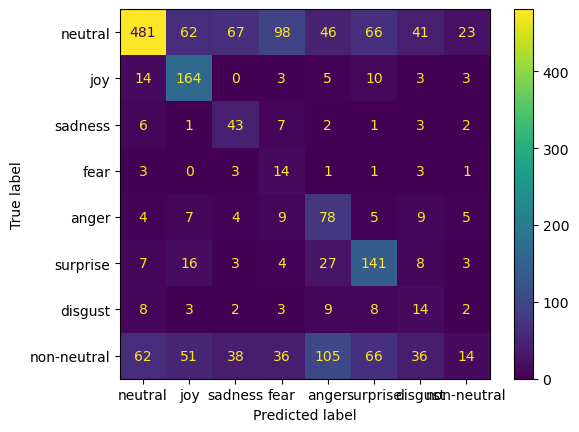

In [60]:
ConfusionMatrixDisplay.from_predictions(preds["labels"], preds["pred"], display_labels=dataset["train"].features["labels"].names)